<a href="https://colab.research.google.com/github/laffertybrian/W_William_Project_001/blob/main/Genetic_Variant_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Libraries
import pandas as pd
import numpy as np
import os, csv, time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, roc_auc_score

Dataset from Kaggle: https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting

In [37]:
# Loading dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Projects/W_William_Project/clinvar_conflicting.csv', dtype={'CHROM': str, 38: str, 40: object})
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

0    48754
1    16434
Name: CLASS, dtype: int64


0    0.747898
1    0.252102
Name: CLASS, dtype: float64

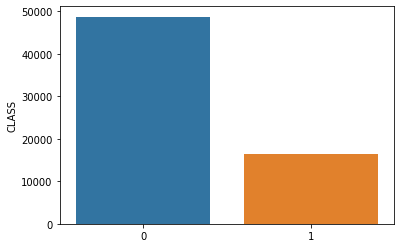

In [39]:
sns.barplot(x = ['0', '1'], y = df['CLASS'].value_counts());
print(df['CLASS'].value_counts());
df['CLASS'].value_counts(normalize=True)

In [40]:
def dataframe_statistics(DF):
  """Takes input of a dataframe and retuns a summary dataframe of key statistics"""

  # initialize lists for data storage
  feature_list = []
  dtype_list = []
  values_list = []
  missing_values_list = []
  data_percent_list = []
  unique_values_list = []
  number_unique_values_list = []

  for column in DF.columns:

    # length and missing values of column
    entries = len(DF[column])
    missing = DF[column].isna().sum()

    feature_list.append(column)
    dtype_list.append(DF[column].dtype)
    values_list.append(entries - missing)
    missing_values_list.append(missing)
    data_percent_list.append(round((entries - missing) / entries, 2))
    unique_values_list.append(DF[column].unique())
    number_unique_values_list.append(len(DF[column].value_counts()))

  # creating summary dataframe for return
  summary = pd.DataFrame({'Features': feature_list, 'Dtype': dtype_list, 
                          '#_Values': values_list, '#_Missing_Values': missing_values_list, 
                          '%_Data': data_percent_list, 'Unique_Values': unique_values_list,
                          '#_Unique_Values': number_unique_values_list})
  
  summary = summary.set_index('Features')
  

  return summary.sort_values(by = '#_Missing_Values', ascending = False)

In [41]:
df_summary = dataframe_statistics(df)
df_summary

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
MOTIF_SCORE_CHANGE,float64,2,65186,0.00,"[nan, -0.063, -0.097]",2
HIGH_INF_POS,object,2,65186,0.00,"[nan, N]",1
MOTIF_POS,float64,2,65186,0.00,"[nan, 1.0]",1
MOTIF_NAME,object,2,65186,0.00,"[nan, Egr1:MA0341.1, FOXA1:MA0546.1]",2
DISTANCE,float64,108,65080,0.00,"[nan, 1811.0, 1855.0, 2202.0, 1651.0, 1407.0, ...",96
SSR,float64,130,65058,0.00,"[nan, 1.0, 16.0]",2
CLNSIGINCL,object,167,65021,0.00,"[nan, 424754:Likely_pathogenic, 30118:risk_fac...",137
CLNDISDBINCL,object,167,65021,0.00,"[nan, MedGen:C1828210,OMIM:153870,Orphanet:ORP...",93
CLNDNINCL,object,167,65021,0.00,"[nan, Bull's_eye_maculopathy|Methylmalonic_aci...",101


####Exploratory Data Analysis

In [42]:
df['Allele'].value_counts()

T                      19991
A                      19800
G                      11397
C                      10761
-                       2510
                       ...  
TCTTCTGCTGCTTCTT           1
AATATTTGCCTC               1
GAAAAATACAGCTTCCTCT        1
AGCAAGTTGGGGTGTGC          1
CGA                        1
Name: Allele, Length: 374, dtype: int64

In [43]:
df['Consequence'].value_counts()

missense_variant                                                  31444
synonymous_variant                                                17668
intron_variant                                                     4403
splice_region_variant&intron_variant                               3393
frameshift_variant                                                 1774
stop_gained                                                        1702
missense_variant&splice_region_variant                              964
5_prime_UTR_variant                                                 626
inframe_deletion                                                    583
splice_region_variant&synonymous_variant                            552
splice_donor_variant                                                539
3_prime_UTR_variant                                                 428
splice_acceptor_variant                                             401
inframe_insertion                                               

In [44]:
consequence_value_count = df['Consequence'].value_counts()
consequence_dictionary = consequence_value_count.to_dict()
consequence_dictionary

{'missense_variant': 31444,
 'synonymous_variant': 17668,
 'intron_variant': 4403,
 'splice_region_variant&intron_variant': 3393,
 'frameshift_variant': 1774,
 'stop_gained': 1702,
 'missense_variant&splice_region_variant': 964,
 '5_prime_UTR_variant': 626,
 'inframe_deletion': 583,
 'splice_region_variant&synonymous_variant': 552,
 'splice_donor_variant': 539,
 '3_prime_UTR_variant': 428,
 'splice_acceptor_variant': 401,
 'inframe_insertion': 202,
 'start_lost': 92,
 'upstream_gene_variant': 82,
 'stop_gained&splice_region_variant': 70,
 'frameshift_variant&splice_region_variant': 56,
 'downstream_gene_variant': 26,
 'stop_gained&frameshift_variant': 25,
 'splice_donor_variant&coding_sequence_variant&intron_variant': 18,
 'splice_donor_variant&intron_variant': 17,
 'splice_region_variant&5_prime_UTR_variant': 15,
 'intergenic_variant': 14,
 'splice_donor_variant&coding_sequence_variant': 10,
 'stop_lost': 10,
 'inframe_deletion&splice_region_variant': 9,
 'protein_altering_variant': 9

In [45]:
df_value_count = df[['Consequence']].copy()
df_value_count.replace(consequence_dictionary, inplace=True)
df_value_count

,Consequence
0,31444
1,31444
2,31444
3,31444
4,31444
...,...
65183,17668
65184,31444
65185,17668
65186,17668


In [46]:
df['IMPACT'].value_counts()

MODERATE    33212
LOW         21642
MODIFIER     5582
HIGH         4752
Name: IMPACT, dtype: int64

In [47]:
df['PolyPhen'].value_counts()

benign               13329
probably_damaging     7531
possibly_damaging     3932
unknown                  4
Name: PolyPhen, dtype: int64

In [48]:
df.groupby(['PolyPhen'])['CLASS'].value_counts()

PolyPhen           CLASS
benign             0        9836
                   1        3493
possibly_damaging  0        2894
                   1        1038
probably_damaging  0        5552
                   1        1979
unknown            0           2
                   1           2
Name: CLASS, dtype: int64

In [49]:
df['SIFT'].value_counts()

deleterious                   11500
tolerated                     11484
tolerated_low_confidence       1077
deleterious_low_confidence      775
Name: SIFT, dtype: int64

In [50]:
df.groupby(['SIFT'])['CLASS'].value_counts()

SIFT                        CLASS
deleterious                 0        8465
                            1        3035
deleterious_low_confidence  0         581
                            1         194
tolerated                   0        8439
                            1        3045
tolerated_low_confidence    0         814
                            1         263
Name: CLASS, dtype: int64

In [51]:
df['Feature_type'].value_counts()

Transcript      65172
MotifFeature        2
Name: Feature_type, dtype: int64

In [52]:
df['CLNVC'].value_counts()

single_nucleotide_variant    61281
Deletion                      2509
Duplication                   1034
Indel                          247
Insertion                       95
Inversion                       17
Microsatellite                   5
Name: CLNVC, dtype: int64

In [53]:
df.groupby('CLNVC')['CLASS'].value_counts()

CLNVC                      CLASS
Deletion                   0         2057
                           1          452
Duplication                0          816
                           1          218
Indel                      0          207
                           1           40
Insertion                  0           81
                           1           14
Inversion                  0           13
                           1            4
Microsatellite             1            3
                           0            2
single_nucleotide_variant  0        45578
                           1        15703
Name: CLASS, dtype: int64

In [54]:
df['BAM_EDIT'].value_counts()

OK        31707
FAILED      262
Name: BAM_EDIT, dtype: int64

In [55]:
df.groupby('BAM_EDIT')['CLASS'].value_counts()

BAM_EDIT  CLASS
FAILED    0          228
          1           34
OK        0        23803
          1         7904
Name: CLASS, dtype: int64

In [56]:
df['ALT'].value_counts()

T                       20409
A                       20205
G                       11782
C                       11429
TA                        118
                        ...  
GCAT                        1
GGAAAAATACAGCTTCCTCT        1
GAGCAAGTTGGGGTGTGC          1
ACAAC                       1
CAAG                        1
Name: ALT, Length: 458, dtype: int64

In [57]:
df['SYMBOL'].value_counts()

TTN      2765
BRCA2    1934
ATM      1909
APC      1228
BRCA1    1075
         ... 
CHIT1       1
REN         1
SYNJ1       1
MRAP        1
CLIC2       1
Name: SYMBOL, Length: 2328, dtype: int64

In [58]:
sorted(df['Feature'].value_counts(),reverse = True)

[2765,
 1934,
 1909,
 1228,
 1075,
 1048,
 905,
 794,
 732,
 640,
 627,
 600,
 596,
 571,
 553,
 491,
 489,
 451,
 441,
 426,
 422,
 420,
 404,
 397,
 395,
 391,
 379,
 359,
 333,
 321,
 320,
 319,
 313,
 311,
 308,
 303,
 290,
 256,
 248,
 237,
 228,
 225,
 220,
 219,
 212,
 210,
 197,
 196,
 195,
 195,
 190,
 187,
 186,
 183,
 182,
 177,
 175,
 171,
 168,
 168,
 168,
 167,
 164,
 162,
 155,
 155,
 152,
 151,
 151,
 151,
 148,
 146,
 146,
 144,
 143,
 141,
 138,
 137,
 136,
 135,
 132,
 131,
 131,
 129,
 128,
 126,
 126,
 126,
 126,
 124,
 124,
 123,
 123,
 123,
 123,
 121,
 118,
 118,
 117,
 115,
 114,
 114,
 112,
 111,
 111,
 111,
 106,
 106,
 105,
 105,
 105,
 104,
 104,
 102,
 100,
 98,
 97,
 96,
 95,
 95,
 95,
 94,
 93,
 92,
 92,
 91,
 91,
 90,
 89,
 88,
 87,
 85,
 85,
 81,
 81,
 80,
 80,
 80,
 79,
 78,
 77,
 77,
 77,
 76,
 76,
 76,
 75,
 75,
 74,
 74,
 73,
 73,
 73,
 73,
 72,
 71,
 71,
 70,
 70,
 70,
 70,
 69,
 69,
 69,
 69,
 68,
 68,
 68,
 67,
 66,
 66,
 66,
 65,
 64,
 64,
 63,

In [59]:
df['Codons'].value_counts()

cGg/cAg        915
Cgg/Tgg        852
cGc/cAc        769
Cga/Tga        734
Cgc/Tgc        730
              ... 
AGCAGCAGC/-      1
ctCTgc/ctgc      1
gCAGag/gag       1
TTGTct/ct        1
tTACTC/t         1
Name: Codons, Length: 2220, dtype: int64

####Value Count Function

In [60]:
# creating function to covert categorical columns to the value count of each variable.
def value_count_converter(dataframe_to_convert):
  """Function that takes a dataframe and converts all categorical columns to the
  value count of the variable."""

  dataframe_to_return = dataframe_to_convert.copy()
  # capturing the categorical columns as a list
  df_cat_cols = list(dataframe_to_convert.select_dtypes('object').columns)

  for col in df_cat_cols:
    feature_value_count = dataframe_to_convert[col].value_counts()
    dataframe_to_return.replace(feature_value_count.to_dict(), inplace=True)

  return dataframe_to_return

####Recording model performance

In [61]:
file_name = "genetic_variant_classification_results"

In [62]:
# attempt at making a folder where the project data can be stored
FOLDER = '/content/drive/MyDrive/Data Science Projects/W_William_Project/Data/'
os.makedirs(FOLDER, exist_ok = True)
os.listdir(FOLDER)

['genetic_variant_classification_results']

In [63]:
# attempt at creating a function to record model data
def record_model_data(input_data, filename):
  folderfile = FOLDER + filename
  file_exists = os.path.isfile(folderfile)
  if file_exists:
    with open(folderfile, 'a', newline='') as f:
      writer = csv.DictWriter(f, fieldnames = fieldnames)
      writer.writerow(input_data)

  else:
    with open(folderfile, 'w', newline='') as f:
      writer = csv.DictWriter(f, fieldnames = fieldnames)
      writer.writeheader()
      writer.writerow(input_data)


# creating a list of feild names for the dataframe storing model runs
fieldnames = ['model', 'time', 'Train_accuracy','Train_recall', 'Train_precision', 
              'Train_ROC_AUC', 'Test_accuracy','Test_recall', 'Test_precision', 
              'Test_ROC_AUC', 'Features_list']

In [64]:
# function to view the data frame header and return the complete data frame
def display_model_data():
  with open(FOLDER+file_name, 'r') as f:
    reader = csv.DictReader(f)
    model_dataframe = pd.DataFrame(reader)


  return model_dataframe


In [65]:
#just_see = display_model_data()
#just_see

####Model Metrics Function

In [66]:
# creating a function to calculate and print the required metrics for each model
def calculate_print_model_metrics(X_train, y_train, y_test, train_pred, test_pred, name, file):
  train_accuracy = accuracy_score(y_train, train_pred)
  train_recall = recall_score(y_train, train_pred)
  train_precision = precision_score(y_train, train_pred)
  train_roc_auc = roc_auc_score(y_train, train_pred)

  test_accuracy = accuracy_score(y_test, test_pred)
  test_recall = recall_score(y_test, test_pred)
  test_precision = precision_score(y_test, test_pred)
  test_roc_auc = roc_auc_score(y_test, test_pred)

  model_features = list(X_train.columns)

  # creating a dictionary for model recording
  model_data = {'model': name, 'time': time.ctime(), 'Train_accuracy': train_accuracy,
              'Train_recall': train_recall, 'Train_precision': train_precision, 
              'Train_ROC_AUC': train_roc_auc, 'Test_accuracy': test_accuracy, 
              'Test_recall': test_recall, 'Test_precision': test_precision, 
              'Test_ROC_AUC': test_roc_auc, 'Features_list': model_features}

  # recording model run in data file
  record_model_data(model_data, file)

  # printing metrics for train and test
  print('-'*18 + name +' Metrics' + '-'*18 + '\n\n')
  print('*'*10 + 'Train Metrics' + '*'*10)
  print(f'Train Accuracy {train_accuracy}')
  print(f'Train Recall Score {train_recall}')
  print(f'Train Precision Score {train_precision}')
  print(f'Train Roc Auc {train_roc_auc}')
  print('\n\n'+'*'*10 + 'Test Metrics' + '*'*10)
  print(f'Test Accuracy {test_accuracy}')
  print(f'Test Recall Score {test_recall}')
  print(f'Test Precision Score {test_precision}')
  print(f'Test Roc Auc {test_roc_auc}')

  # printing confusion chart
  ConfusionMatrixDisplay.from_predictions(y_test, test_pred, cmap='Blues');

###Feature selection

In [67]:
# I think PolyPhen is a critical column. droping the rows with nan values and seeing what is left of the dataframe.
df_poly = df[df['PolyPhen'].notna()]
df_poly = df_poly[df_poly['LoFtool'].notna()]
df_poly = df_poly[df_poly['CADD_RAW'].notna()]
df_poly = df_poly[df_poly['SIFT'].notna()]
df_poly_summary = dataframe_statistics(df_poly)

columns_to_drop_poly = list(df_poly_summary[df_poly_summary["#_Missing_Values"] > 1].index)

df_poly.drop(columns = columns_to_drop_poly, inplace = True)
df_poly_summary = dataframe_statistics(df_poly)
df_poly_summary

,Dtype,#_Values,#_Missing_Values,%_Data,Unique_Values,#_Unique_Values
Features,,,,,,
CHROM,object,23064,0,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",23
SYMBOL,object,23064,0,1.0,"[NPHP4, RERE, PIK3CD, NMNAT1, PEX14, MASP2, MT...",1474
CADD_PHRED,float64,23064,0,1.0,"[22.1, 26.1, 6.773, 22.2, 29.0, 25.3, 18.05, 2...",3646
LoFtool,float64,23064,0,1.0,"[0.021, 0.0674, 0.183, 0.3, 0.372, 0.273, 0.21...",985
PolyPhen,object,23064,0,1.0,"[benign, probably_damaging, possibly_damaging,...",4
SIFT,object,23064,0,1.0,"[deleterious, tolerated, deleterious_low_confi...",4
STRAND,float64,23064,0,1.0,"[-1.0, 1.0]",2
Codons,object,23064,0,1.0,"[aCg/aTg, Cgg/Tgg, gCg/gTg, cGc/cAc, cGg/cAg, ...",411
Amino_acids,object,23064,0,1.0,"[T/M, R/W, A/V, R/H, R/Q, V/I, G/R, E/K, A/G, ...",158


In [68]:
# getting the object columns from poly 
poly_cat_cols = df_poly.select_dtypes('object').columns
poly_cat_cols

Index(['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature',
       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'SIFT', 'PolyPhen'],
      dtype='object')

In [69]:
poly_cat_cols_to_drop = ['CLNHGVS', 'CLNDISDB', 'POS', 'CADD_RAW']
df_poly.drop(columns = poly_cat_cols_to_drop, inplace = True)
#df_poly_vc = value_count_converter(df_poly)

In [70]:
#mikes_cols_to_drop = ['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'MC',
#       'Allele', 'SYMBOL', 'Feature_type', 'Feature',
#       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
#       'Amino_acids', 'Codons']
#mikes = df_poly.drop(columns = mikes_cols_to_drop)
#num_cols = df_poly.select_dtypes('number').columns
#mikes = mikes.drop(columns = ['POS', 'CADD_RAW'])


In [71]:
#mikes_summary = dataframe_statistics(mikes)
#mikes_summary

In [72]:
#mikes['CLASS'].value_counts()

In [73]:
#df.drop(df[df['Codons'].isna()].index, inplace=True)
#df.drop(df[df['CADD_RAW'].isna()].index, inplace=True)
#df.drop(df[df['MC'].isna()].index, inplace=True)
#df.drop(df[df['LoFtool'].isna()].index, inplace=True)
#df.drop(df[df['EXON'].isna()].index, inplace=True)

In [74]:
#df_summary_1 = dataframe_statistics(df)
#df_summary_1

In [75]:
# columns with data less than 100%
#columns_to_drop = list(df_summary_1[df_summary_1["#_Missing_Values"] > 1].index)

#df.drop(columns = columns_to_drop, inplace = True)

#summary = dataframe_statistics(df)
#summary

####Data imputing selection test

In [77]:
# creating a dataframe that has numeric and categorical missing data. This will test the imputers in the pipelines
df_impute_test = df.copy()
df_impute_test_summary = dataframe_statistics(df_impute_test)

columns_to_drop_impute_test = list(df_impute_test_summary[df_impute_test_summary["%_Data"] < .85].index)
df_impute_test.drop(columns = columns_to_drop_impute_test, inplace=True)
df_impute_test_summary = dataframe_statistics(df_impute_test)

In [79]:
df_impute_test.drop(columns=poly_cat_cols_to_drop, inplace=True)

###Prepare data for modling

In [ ]:
#cat_cols_except_Consequence_CLNVC_IMPACT = ['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'MC',
#       'Allele', 'SYMBOL', 'Feature_type', 'Feature',
#       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
#       'Amino_acids', 'Codons']

In [ ]:
#cat_cols_except_Consequence_CLNVC_IMPACT_MC = ['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS',
#       'Allele', 'SYMBOL', 'Feature_type', 'Feature',
#       'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position',
#       'Amino_acids', 'Codons']

In [ ]:
# dropping all object columns for simple model creation
#cat_cols = df.select_dtypes('object').columns
#df.drop(columns = cat_cols, inplace = True)
#df.drop(columns = cat_cols_except_Consequence_CLNVC_IMPACT_MC, inplace = True)

In [80]:
# creating feature matrix and target vector
#X = df.drop(columns = 'CLASS')
X = df_impute_test.drop(columns = 'CLASS')
#X = mikes.drop(columns = 'CLASS')
#y = df['CLASS']
y = df_impute_test['CLASS']
#y = mikes['CLASS']

In [81]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [82]:
# creating column selectors
numerical_cols = make_column_selector(dtype_include='number')

category_cols = make_column_selector(dtype_include='object')

# instantiate scaler and onehotencoder
scaler = StandardScaler()

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)

# instantiate imputers
numeric_imputer = SimpleImputer(strategy='most_frequent')
category_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# creating pipelines
numeric_pipe = make_pipeline(numeric_imputer, scaler)
category_pipe = make_pipeline(category_imputer, one_hot_encoder)

# creating tuples for use in the transformer
numeric_tuple = (numeric_pipe, numerical_cols)
category_tuple = (category_pipe, category_cols)

# column transformer
preprocessor = make_column_transformer(numeric_tuple, category_tuple, remainder='passthrough')
#preprocessor = make_column_transformer(numeric_tuple, remainder='passthrough')

In [ ]:
# transform train and test dataset
#preprocessor.fit(X_train)
#X_train_processed = preprocessor.transform(X_train)
#X_test_processed = preprocessor.transform(X_test)

###Model Construction


####Logistic Regression

In [ ]:
# creating an instance of logistic regression
logistic_regression = LogisticRegression(max_iter = 1000, random_state=42)
# creating a pipeline for the preprossor and the model
logistic_regression_pipe = make_pipeline(preprocessor, logistic_regression)
# fitting the log reg pipe on the training data
logistic_regression_pipe.fit(X_train, y_train)
# using the logistics regression model to predict for train and test data
logistic_regression_train_predictions = logistic_regression_pipe.predict(X_train)
logistic_regression_test_predictions = logistic_regression_pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------Logistic_Regression Metrics------------------


**********Train Metrics**********
Train Accuracy 0.7407792808417158
Train Recall Score 0.0
Train Precision Score 0.0
Train Roc Auc 0.5


**********Test Metrics**********
Test Accuracy 0.7402011793270898
Test Recall Score 0.0
Test Precision Score 0.0
Test Roc Auc 0.5


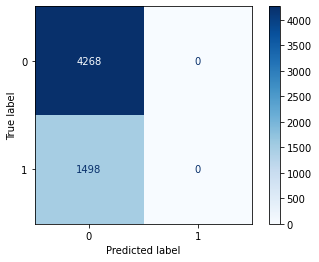

In [ ]:
# calculating model metrics and printing results
calculate_print_model_metrics(X_train, y_train, y_test, logistic_regression_train_predictions, 
                              logistic_regression_test_predictions, 'Logistic Regression', file_name)

#####SMOTE Logistic Regression

In [ ]:
# using SMOTE to oversample the data set and bring 50/50 balance to CLASS

# instantiate SMOTE
smote = SMOTE(sampling_strategy='auto')
# creating a pipeline for smote and fitting on training data
logistic_regression_smote = smote_pipe(scaler, smote, logistic_regression)
logistic_regression_smote.fit(X_train, y_train)
# creating predictions from the SMOTE pipeline
logistic_regression_smote_train_predictions = logistic_regression_smote.predict(X_train)
logistic_regression_smote_test_predictions = logistic_regression_smote.predict(X_test)

------------------Logistic Regression SMOTE Metrics------------------


**********Train Metrics**********
Train Accuracy 0.562955254942768
Train Recall Score 0.6888938447814451
Train Precision Score 0.3338015993084072
Train Roc Auc 0.6038897193315684


**********Test Metrics**********
Test Accuracy 0.5648629899410337
Test Recall Score 0.6809078771695594
Test Precision Score 0.3343166175024582
Test Roc Auc 0.6025204802904967


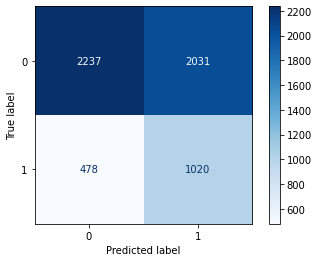

In [ ]:
# calculating model metrics and printing results
calculate_print_model_metrics(X_train, y_train, y_test, logistic_regression_smote_train_predictions, 
                              logistic_regression_smote_test_predictions, 'Logistic Regression SMOTE', file_name)

#####GridSearchCV SMOTE Logistic Regression

In [ ]:
# creating a new pipeline to use with GridSearchCV
smote_grid_log_reg_pipe = smote_pipe(scaler, smote, LogisticRegression())
smote_grid_log_reg_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('smote', SMOTE()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'smote': SMOTE(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logistic

In [ ]:
smote_log_reg_param_grid = {'logisticregression__C': [.5, 1.0, 2.0],
                            'logisticregression__max_iter': [100, 500, 1000]}

# instantiate gridsearch
log_reg_smote_grid = GridSearchCV(smote_grid_log_reg_pipe, smote_log_reg_param_grid, scoring='accuracy')
log_reg_smote_grid.fit(X_train, y_train)

print('Best Logisitic Regression Parameters')
print(log_reg_smote_grid.best_params_)

best_run = log_reg_smote_grid.best_estimator_

logistic_regression_smote_gs_train_predictions = best_run.predict(X_train)
logistic_regression_smote_gs_test_predictions = best_run.predict(X_test)

Best Logisitic Regression Parameters
{'logisticregression__C': 0.5, 'logisticregression__max_iter': 1000}


------------------Logistic Regression SMOTE GridSearchCV Metrics------------------


**********Train Metrics**********
Train Accuracy 0.5623193432766794
Train Recall Score 0.6862176628010704
Train Precision Score 0.3329726220106049
Train Roc Auc 0.6025906481634509


**********Test Metrics**********
Test Accuracy 0.565383281304197
Test Recall Score 0.6748998664886515
Test Precision Score 0.3336633663366337
Test Roc Auc 0.6009222856342039


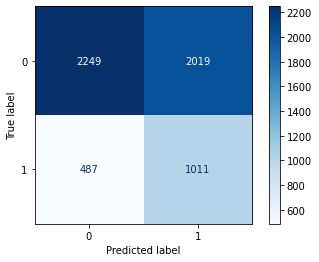

In [ ]:
# calculating model metrics and printing results
calculate_print_model_metrics(X_train, y_train, y_test, logistic_regression_smote_gs_train_predictions, 
                              logistic_regression_smote_gs_test_predictions, 'Logistic Regression SMOTE GridSearchCV', file_name)

####Random Forest

In [ ]:
# Instantiate random forest model
random_forest = RandomForestClassifier(random_state=42)
# creating pipeline for data and model
random_forest_pipe = make_pipeline(preprocessor, random_forest)
# fit the model with the training data
random_forest_pipe.fit(X_train, y_train)
# predict with the random forest model
random_forest_test_predictions = random_forest_pipe.predict(X_test)
random_forest_train_predictions = random_forest_pipe.predict(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------Random_Forest Metrics------------------


**********Train Metrics**********
Train Accuracy 0.7407792808417158
Train Recall Score 0.0
Train Precision Score 0.0
Train Roc Auc 0.5


**********Test Metrics**********
Test Accuracy 0.7402011793270898
Test Recall Score 0.0
Test Precision Score 0.0
Test Roc Auc 0.5


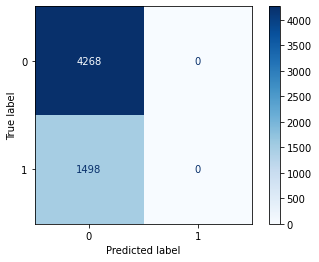

In [ ]:
# calculating model metrics and printing results
calculate_print_model_metrics(X_train, y_train, y_test, logistic_regression_train_predictions, 
                              logistic_regression_test_predictions, 'Random Forest', file_name)

####KNN

In [ ]:
# Instantiating the knn model
knn = KNeighborsClassifier()
# creating a pipe and adding a scaler
knn_pipe = make_pipeline(preprocessor, knn)
# fitting the pipeline on the training data
knn_pipe.fit(X_train, y_train)
# predictions with knn model
knn_test_predictions = knn_pipe.predict(X_test)
knn_train_predictions = knn_pipe.predict(X_train)

------------------KNN Metrics------------------


**********Train Metrics**********
Train Accuracy 0.7407792808417158
Train Recall Score 0.0
Train Precision Score 0.0
Train Roc Auc 0.5


**********Test Metrics**********
Test Accuracy 0.7402011793270898
Test Recall Score 0.0
Test Precision Score 0.0
Test Roc Auc 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


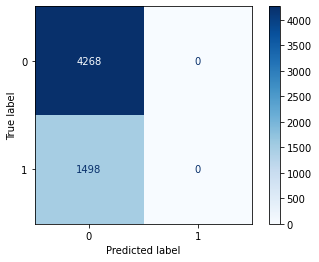

In [ ]:
# calculating model metrics and printing results
calculate_print_model_metrics(X_train, y_train, y_test, logistic_regression_train_predictions, 
                              logistic_regression_test_predictions, 'KNN', file_name)

####Neural Network

In [ ]:
# prepare dataset
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# storing the dimension of X train
X_train_shape = X_train_processed.shape[1]
X_train_shape

12

In [ ]:
# Function to help plot history of deep learning models

#def plot_history(history):
#  """Takes a keras model learning history and plots each metric"""
  
#  metrics = history.history.keys()
  
#  for metric in metrics:
#      if not 'val' in metric:
#        plt.plot(history.history[f'{metric}'], label=f'{metric}')
#        if f'val_{metric}' in metrics:
#          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
#        plt.legend()
#        plt.title(f'{metric}')
#        plt.show()

In [ ]:
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

In [ ]:
# instantiate the base sequential model
base_model = Sequential()
# creating the first layer of the model
base_model.add(Dense(150, input_dim = X_train_shape, activation = 'relu'))
# adding addtional layers
base_model.add(Dense(150, activation = 'relu'))
# because this is a binary classification problem the last step will have one node and be a sigmoid activiation function
base_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# add different metrics to track/view

In [ ]:
# fittting the model
history = base_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs = 50, verbose = 0)

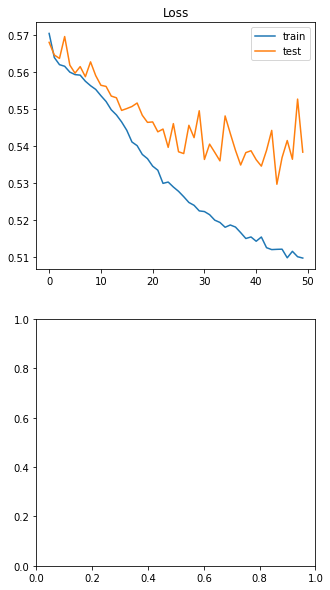

In [ ]:
# plotting the history using the function above
plot_history(history)

181/181 [==============================] - 0s 1ms/step
Training Classification Report and Confusion Matrix
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     12814
           1       0.61      0.16      0.25      4484

    accuracy                           0.76     17298
   macro avg       0.69      0.56      0.55     17298
weighted avg       0.73      0.76      0.70     17298

Neural Network Accuracy 0.7559833506763788


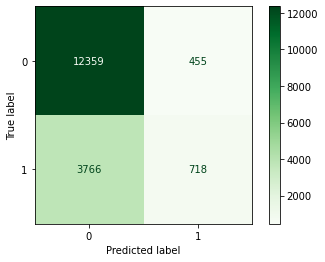

In [ ]:
# creating training and testing predictions. making sure to round them
nn_train_predictions = np.rint(base_model.predict(X_train_processed))
nn_test_predictions = np.rint(base_model.predict(X_test_processed))

# training classification report
print('Training Classification Report and Confusion Matrix')
print(classification_report(y_train, nn_train_predictions))
print(f'Neural Network Accuracy {accuracy_score(y_train, nn_train_predictions)}')

# creating the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, nn_train_predictions, cmap='Greens');

Testing Classification Report and Confusion Matrix
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      4268
           1       0.52      0.13      0.20      1498

    accuracy                           0.74      5766
   macro avg       0.64      0.54      0.53      5766
weighted avg       0.70      0.74      0.68      5766

Neural Network Accuracy 0.7428026361429066


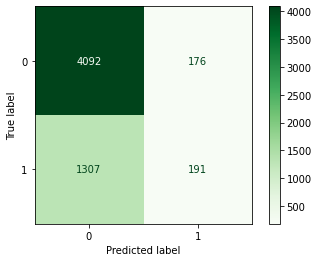

In [ ]:
# testing classification report
print('Testing Classification Report and Confusion Matrix')
print(classification_report(y_test, nn_test_predictions))
print(f'Neural Network Accuracy {accuracy_score(y_test, nn_test_predictions)}')

# confusion matrix for the testing set
ConfusionMatrixDisplay.from_predictions(y_test, nn_test_predictions, cmap='Greens');